Sentiment analysis with hotel reviews

**Introduction**
Sentiment analysis is a branch of Natural Language Processing (NLP) that focuses on identifying and interpreting emotions expressed in unstructured text. It is commonly applied to social media content and customer reviews to automatically determine whether users express positive or negative opinions, as well as the reasons behind them. The objective of this study is to demonstrate how sentiment analysis can be implemented using Python. To achieve this, we will rely on several key libraries:

NLTK: one of the most widely used Python libraries for NLP tasks
Gensim: a toolkit designed for topic modeling and vector space representations
Scikit-learn: a popular Python library for machine learning

In this project, we will work with a dataset of hotel reviews, where each entry represents a single customer’s review of a hotel. Each review includes written feedback describing the customer’s experience along with an overall rating score. 

The goal is to determine whether a given review reflects a positive experience (a satisfied customer) or a negative one (an unsatisfied customer) based solely on the review text. The ratings range from 2.5/10 to 10/10, but for simplicity, we will convert them into two classes:

Bad reviews: overall rating below 5
Good reviews: overall rating of 5 or higher

**Import libraries and Load the Dataset**

In [1]:
import pandas as pd
import nltk

# Download data required for pos_tag
nltk.download('averaged_perceptron_tagger')
# Download data required for stopwords and wordnet lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
# 'omw' (Open Multilingual Wordnet) supports wordnet lemmatization
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

# Read the data
reviews_df = pd.read_csv('G:\IOT_AI\FinalProjHotelReview\Hotel_Reviews\Hotel_Reviews.csv')
# Append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# Create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# Select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SAMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SAMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SAMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SAMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\SAMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\SAMAR\AppData\Roamin

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


**Sample Data**

In [2]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

**Clean Data**

If a user does not provide negative feedback, it appears as “No Negative” in the dataset, and similarly “No Positive” is used when no positive comment is given. These placeholder values must be removed from the text data.

In [3]:
# Remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

**Next step is cleaning the data with different operations**
To clean textual data, we call our custom 'clean_text' function that performs several transformations:
Lower the text
Tokenize the text (split the text into words) and remove the punctuation
Remove useless words that contain numbers
Remove useless stop words like 'the', 'a' ,'this' etc.
Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
Lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)
Now that we have cleaned our data, we can do some feature engineering for our modelization part.

In [4]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

**Adding sentiment analysis column.**
We begin by adding sentiment features, as customer reviews strongly reflect their hotel experience. We use VADER, a sentiment analysis tool from the NLTK library, which relies on a word lexicon and sentence context to compute sentiment. For each review, VADER produces four scores: neutral, positive, negative, and an overall sentiment score. These four values are added as features to our dataset.

In [5]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

Next, we add some simple metrics for every text:
Number of characters in the text
Number of words in the text

In [6]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

The next step is to extract vector representations for each review. Using Gensim, we generate numerical word vectors based on the contexts in which words appear through Word2Vec, which is built with shallow neural networks. As a result, words with similar meanings have similar vector representations.
Entire reviews can also be converted into vectors using Doc2Vec, where similar texts obtain similar representations. These vectors can then be used as features for training our model.
To do this, we first train a Doc2Vec model on our text data and then apply it to the reviews to obtain their vector representations.

In [7]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

**Add the TF-IDF (Term Frequency — Inverse Document Frequency) values for every words to find out which word that has useful information for analysis.**
The TF-IDF metric solves this problem:
TF computes the classic number of times the word appears in the text
IDF computes the relative importance of this word which depends on how many texts the word can be found

In [8]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [9]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zuid
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,-0.227174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,-0.080353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,-0.088277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,-0.204932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,0.040687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
reviews_df.shape

(51574, 3840)

**Exploratory data analysis**
Lets explore a little to have a better understanding of our data

In [11]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

is_bad_review
0    0.956761
1    0.043239
Name: proportion, dtype: float64

Our dataset is highly imbalanced because less than 5% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

Now let's print some wordclouds to have a glimpse at what kind of words apear in our reviews:
Positive / Negative Reviews wordCloud

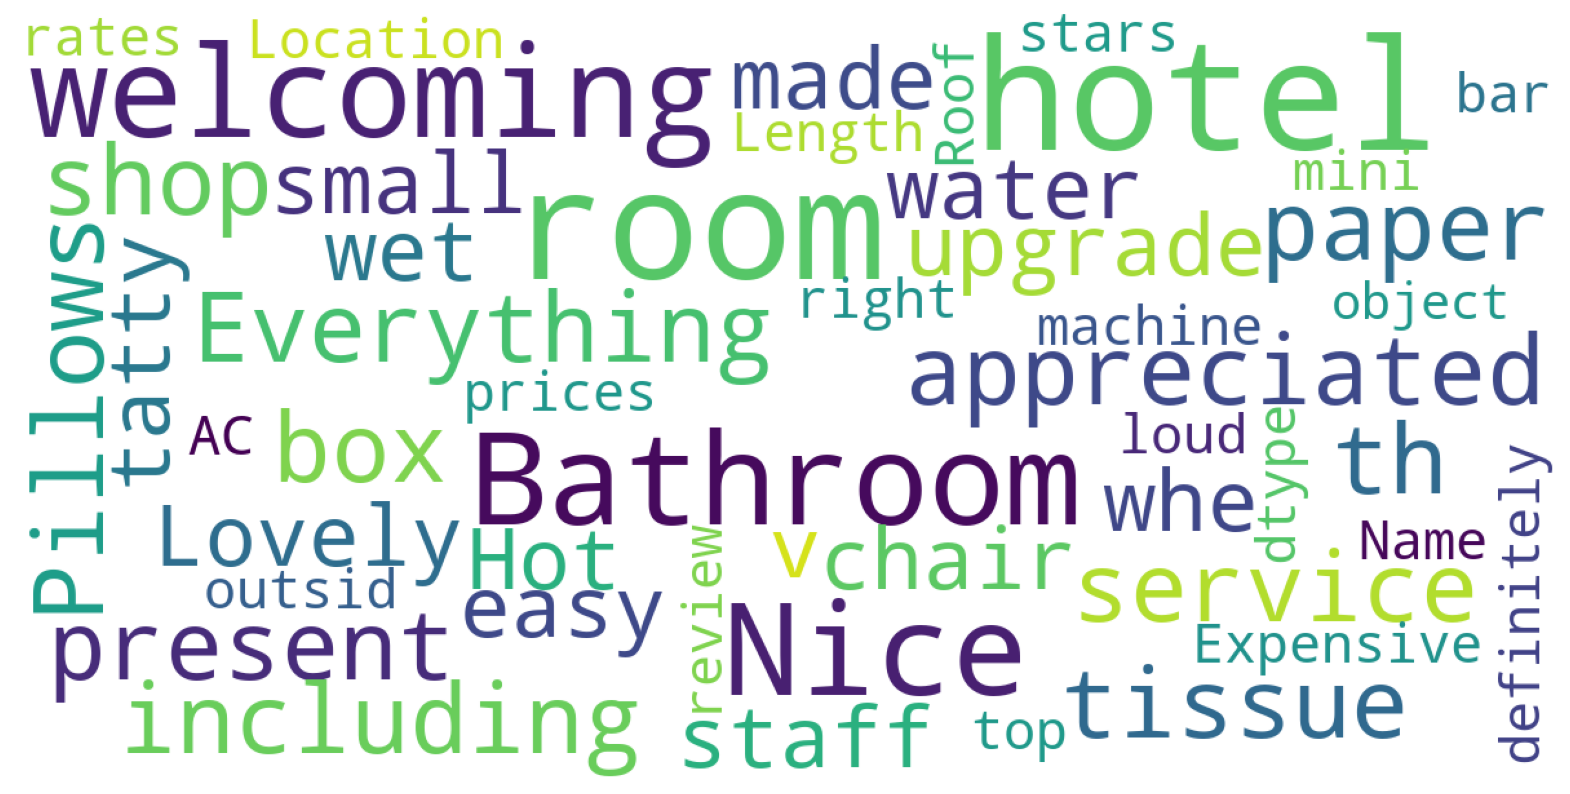

In [12]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

Most of the words are indeed related to the hotels: room, staff, breakfast, etc. Some words are more related to the customer experience with the hotel stay: perfect, loved, expensive, dislike, etc.

In [13]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
43101,A perfect location comfortable great value,0.931
211742,Clean comfortable lovely staff,0.907
175551,Friendly welcome Comfortable room,0.905
365085,Good location great value,0.904
109564,Clean friendly and comfortable,0.902
145743,Good value amazing location,0.901
407590,breakfast excellent Clean comfort,0.899
407546,Great place I enjoyed,0.881
218571,Beautiful Quirky Comfortable,0.878
128308,Super friendly staff,0.877


In [14]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
193086,No dislikes LOCATION,0.831
356368,Nothing Great helpful wonderful staff,0.812
318516,A disaster Nothing,0.804
458794,Nothing Excellent friendly helpful staff,0.799
29666,A bit noisy No,0.796
426057,Dirty hotel Smells bad,0.762
263187,Very bad service No,0.758
443796,Nothing perfect,0.750
181508,Window blind was broken,0.744
175316,Nothing Super friendly staff,0.743


Some errors appear among the most negative reviews: VADER occasionally treats words like “no” or “nothing” as negative, even when they are used to indicate the absence of problems. Fortunately, the majority of these reviews are genuinely negative.

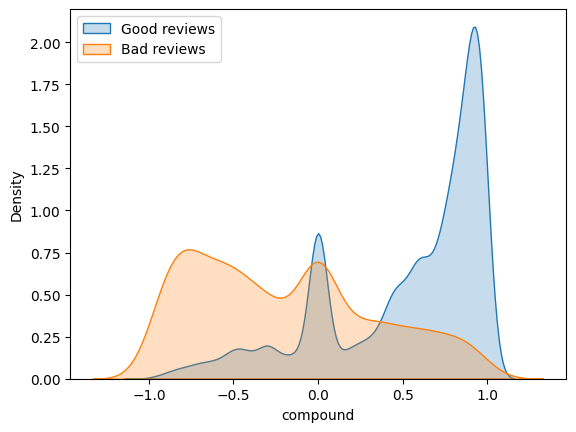

In [29]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

ax = plt.gca() 
for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    #sns.displot(subset['compound'], kind = "kde", label = label, legend=True)  
    sns.kdeplot(subset['compound'], label=label, fill=True)
    plt.legend()   

The graph above illustrates how sentiment scores are distributed between good and bad reviews. Most good reviews are rated as highly positive by VADER, while bad reviews generally have lower compound sentiment scores. This confirms that the sentiment features computed earlier will play a key role in the modeling process.

**MACHINE LEARNING MODELING
Data Pre-Processing**

We first choose which features we want to use to train our model. Then we split our data into two parts:
one to train our model
one to assess its performances
We will next use a Random Forest (RF) classifier for our predictions.

Random Forest is a popular machine learning algorithm developed by Leo Breiman and Adele Cutler that combines the results of multiple decision trees into a single prediction. It is easy to use, flexible, and supports both classification and regression tasks.
The algorithm performs well on large datasets, delivers high predictive accuracy, and often outperforms a single decision tree while remaining relatively easy to interpret.

In [16]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.036370
2,pos,0.024212
0,neg,0.022637
6,doc2vec_vector_0,0.019826
9,doc2vec_vector_3,0.019185
10,doc2vec_vector_4,0.018919
8,doc2vec_vector_2,0.018194
7,doc2vec_vector_1,0.017533
4,nb_chars,0.016261
1,neu,0.014438


The **ROC (Receiver Operating Characteristic)** curve is often used to evaluate classifier performance: the further the curve is above the diagonal line, the better the model. Although the AUC-ROC value appears high in our case, it is not the most appropriate metric for evaluating this model.

The reason lies in the False Positive Rate (FPR), which is shown on the x-axis of the ROC curve and is defined as:
FPR = number of false positives / number of negatives.

In our dataset, the number of negative cases (good reviews) is very large due to class imbalance. As a result, even if the model produces many false positives, the FPR remains low. This can lead to an inflated true positive rate and an overly optimistic AUC-ROC score that does not accurately reflect the model’s real performance.

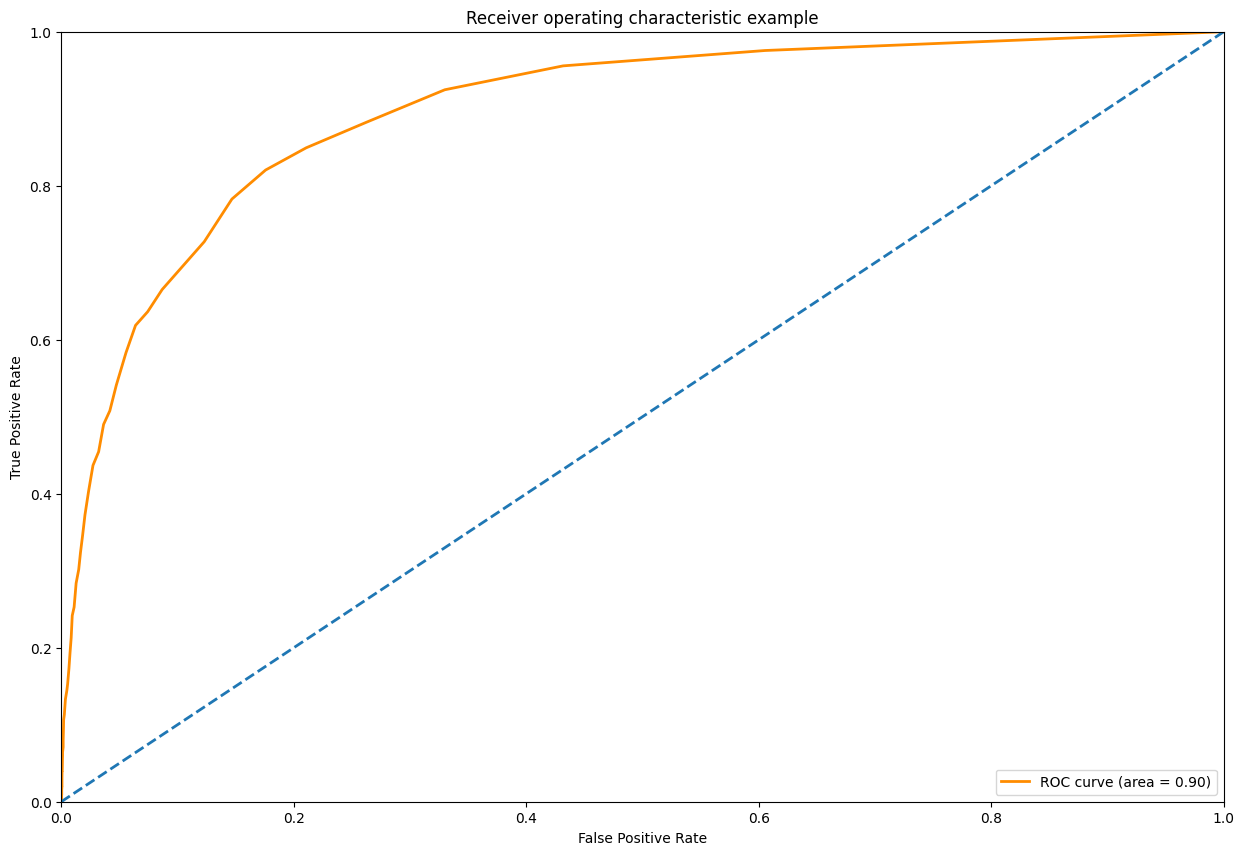

In [17]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In an imbalanced setting, a more suitable metric is **AUC-PR (Area Under the Precision–Recall Curve)**, also known as Average Precision (AP).

As recall increases, precision typically decreases, highlighting the need to choose a prediction threshold based on our objectives. A low threshold favors high recall, allowing most positive cases to be detected but with lower precision. Conversely, a high threshold increases precision but reduces recall, meaning fewer positive cases are identified.

To evaluate model performance, AP can be directly compared across classifiers. As a baseline, consider a random classifier that predicts class 1 half of the time and class 0 the other half. Such a model would achieve a precision equal to the proportion of positive samples (4.3%), resulting in an AP of 0.043.

Our model achieves an AP of about 0.35, which is more than eight times higher than the random baseline, indicating strong predictive performance.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.37')

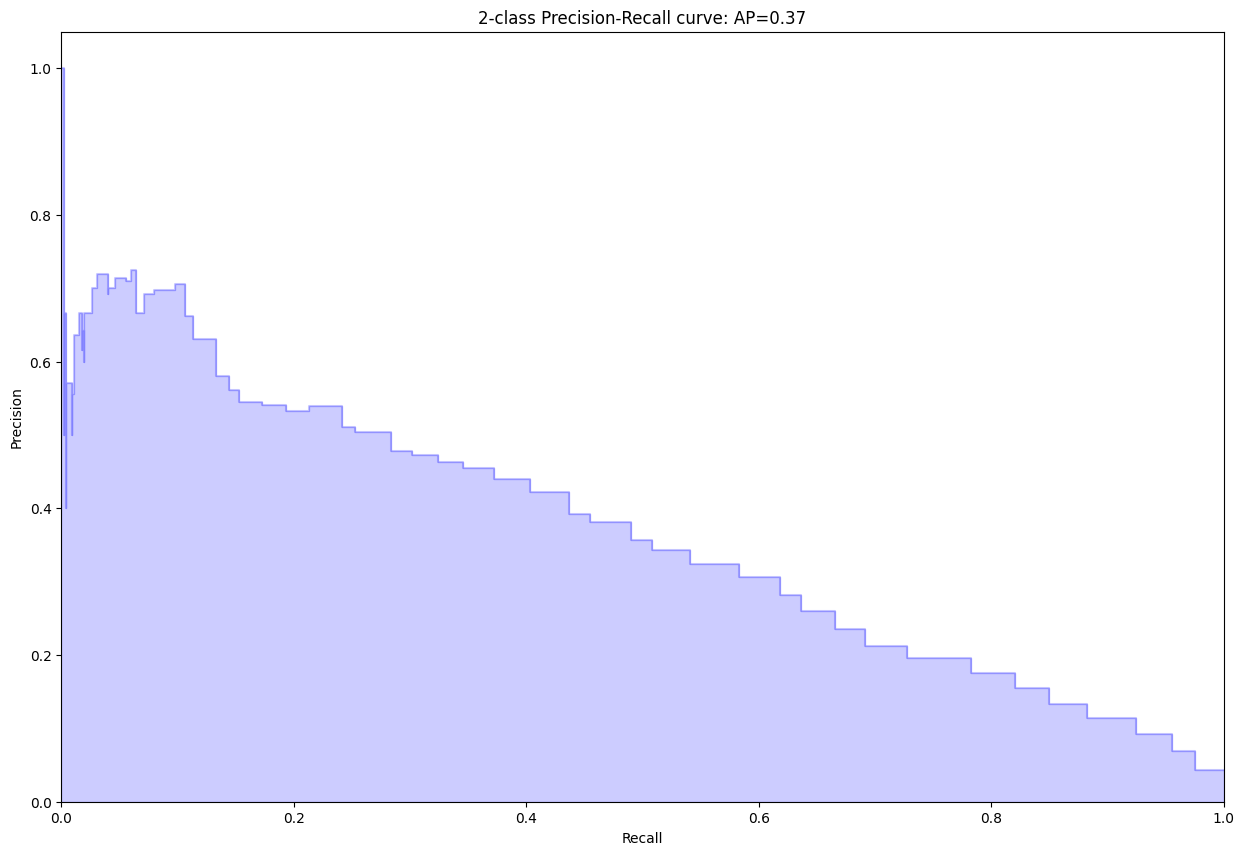

In [18]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from inspect import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

**Conclusion**
It is entirely possible to make predictions using only raw text as input. The key is extracting meaningful features from this unstructured data. Text data often serves as a valuable complementary source in data science projects, helping to enrich feature sets and improve model predictive performance.